SOUID: Source identifier  
DATE : Date YYYYMMDD  
TG   : mean temperature in 0.1 &#176;C  
Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [43]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
mpl.rcParams['figure.figsize'] = (12,6)

In [44]:
df = pd.read_csv('TG_STAID002759.txt', skiprows=19)
df.columns

Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [45]:
df = df.rename(columns={' SOUID':'source','    DATE':'date','   TG': 'temp',' Q_TG': 'q_code'})
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['year'] =  df['date'].dt.year
df['month'] = df['date'].dt.month
df['season'] = ['winter' if 1<=x<=2 else 'spring' if 3<=x<=5 else 'summer' if 6<=x<=8 else 'autumn' for x in df['month']]
df=df.set_index(['date'])
df.head(12)

,source,temp,q_code,year,month,season
date,,,,,,
1876-01-01,127488,22,0,1876,1,winter
1876-01-02,127488,25,0,1876,1,winter
1876-01-03,127488,3,0,1876,1,winter
1876-01-04,127488,-58,0,1876,1,winter
1876-01-05,127488,-98,0,1876,1,winter
1876-01-06,127488,-77,0,1876,1,winter
1876-01-07,127488,-66,0,1876,1,winter
1876-01-08,127488,-89,0,1876,1,winter
1876-01-09,127488,-127,0,1876,1,winter


In [46]:
#Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')
df['q_code'].value_counts()

0    52490
9      195
1        1
Name: q_code, dtype: int64

In [47]:
# Dropping missing values
df = df.loc[df['q_code'] != 9]
df = df.loc[df['q_code'] != 1]
df

,source,temp,q_code,year,month,season
date,,,,,,
1876-01-01,127488,22,0,1876,1,winter
1876-01-02,127488,25,0,1876,1,winter
1876-01-03,127488,3,0,1876,1,winter
1876-01-04,127488,-58,0,1876,1,winter
1876-01-05,127488,-98,0,1876,1,winter
...,...,...,...,...,...,...
2020-03-27,111448,92,0,2020,3,spring
2020-03-28,111448,79,0,2020,3,spring
2020-03-29,111448,29,0,2020,3,spring


In [48]:
df['temp'].describe()

count    52490.000000
mean        93.666546
std         78.785065
min       -226.000000
25%         33.000000
50%         94.000000
75%        157.000000
max        305.000000
Name: temp, dtype: float64

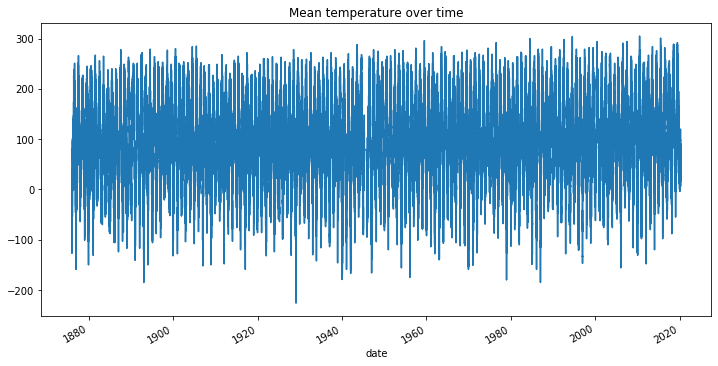

In [49]:
df.temp.plot(figsize=(12,6), title='Mean temperature over time')
plt.show()

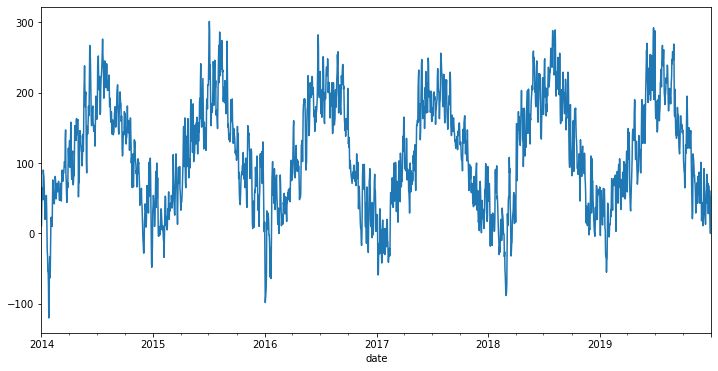

In [50]:
df_10=df['2014':'2019']
df_10['temp'].plot(figsize=(12,6))

### Train-test split

In [51]:
start_value = '2010'
y_train = df[start_value:'2017']
y_test = df['2018':'2019']

### Detrend/Deseasonalize

In [52]:
def detrend_deseasonalize(df_d):
    # De-trend the series through differencing
    df_d['detrended'] = df_d['temp'].diff()
    # De-seasonalize the series
    df_d['yearly_means'] = df_d.groupby('year')['detrended'].transform('mean')
    df_d['deseasonalized'] = df_d['detrended'] - df_d['yearly_means']
    print(df_d['detrended'].mean())
    return df_d

In [53]:
y_train = detrend_deseasonalize(y_train)
y_test = detrend_deseasonalize(y_test)

0.03731598767545361
-0.03429355281207133


In [54]:
y_train_mm = pd.DataFrame(y_train.groupby(['year','month'])['temp'].mean()).reset_index()
y_test_mm = pd.DataFrame(y_test.groupby(['year','month'])['temp'].mean()).reset_index()
y_train_mm['date'] = pd.to_datetime(y_train_mm[['year', 'month']].assign(Day=1))
y_test_mm['date'] = pd.to_datetime(y_test_mm[['year', 'month']].assign(Day=1))
y_train_mm=y_train_mm.set_index('date')
y_test_mm=y_test_mm.set_index('date')

In [55]:
y_train

,source,temp,q_code,year,month,season,detrended,yearly_means,deseasonalized
date,,,,,,,,,
2010-01-01,111448,-14,0,2010,1,winter,NaN,0.057692,NaN
2010-01-02,111448,-17,0,2010,1,winter,-3.0,0.057692,-3.057692
2010-01-03,111448,-43,0,2010,1,winter,-26.0,0.057692,-26.057692
2010-01-04,111448,-56,0,2010,1,winter,-13.0,0.057692,-13.057692
2010-01-05,111448,-60,0,2010,1,winter,-4.0,0.057692,-4.057692
...,...,...,...,...,...,...,...,...,...
2017-12-27,111448,30,0,2017,12,autumn,-20.0,0.238356,-20.238356
2017-12-28,111448,31,0,2017,12,autumn,1.0,0.238356,0.761644
2017-12-29,111448,17,0,2017,12,autumn,-14.0,0.238356,-14.238356


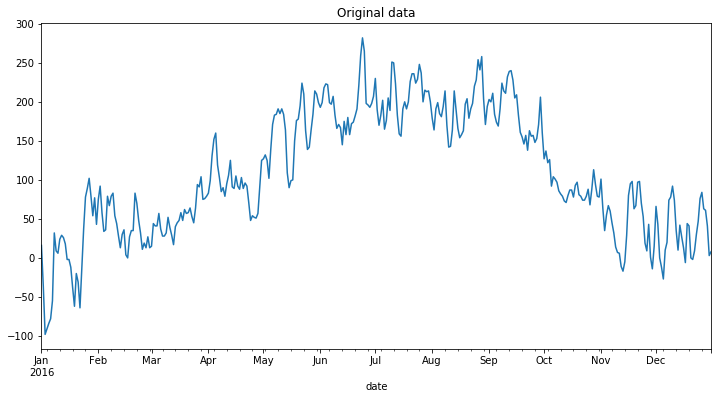

In [56]:
df['temp']['2016'].plot(title='Original data')

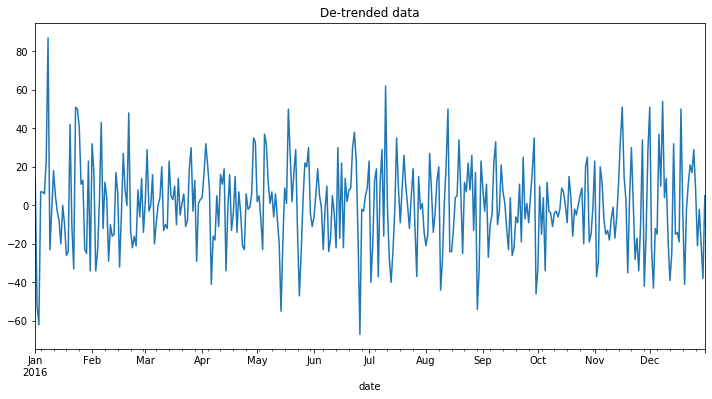

In [57]:
y_train['detrended']['2016'].plot(title='De-trended data')

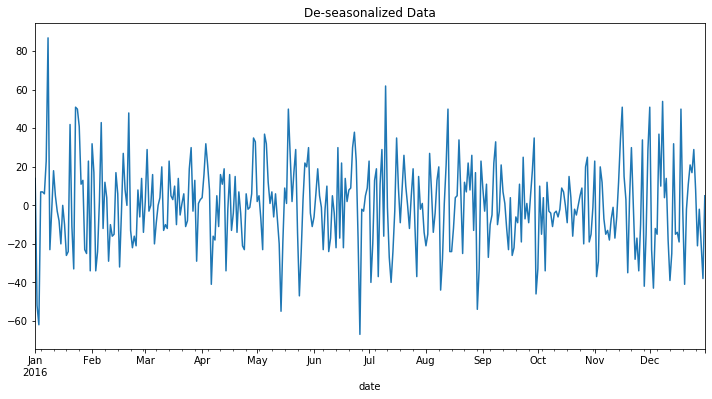

In [58]:
y_train['deseasonalized']['2016'].plot(title='De-seasonalized Data')

### Seasonal_decompose

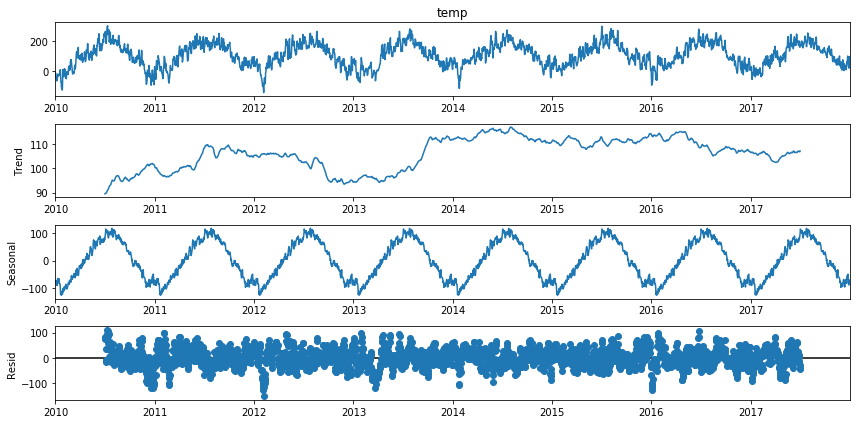

In [59]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose as sm
decomp = sm(y_train.temp, period=365, model ='additive')
decomp.plot()
plt.show()

In [60]:
print(decomp.trend)

date
2010-01-01   NaN
2010-01-02   NaN
2010-01-03   NaN
2010-01-04   NaN
2010-01-05   NaN
              ..
2017-12-27   NaN
2017-12-28   NaN
2017-12-29   NaN
2017-12-30   NaN
2017-12-31   NaN
Name: trend, Length: 2922, dtype: float64


In [61]:
print(decomp.seasonal)

date
2010-01-01   -75.543696
2010-01-02   -71.787532
2010-01-03   -80.890467
2010-01-04   -85.722561
2010-01-05   -90.718647
                ...    
2017-12-27   -86.753089
2017-12-28   -89.597708
2017-12-29   -83.579704
2017-12-30   -75.543696
2017-12-31   -71.787532
Name: seasonal, Length: 2922, dtype: float64


In [62]:
print(decomp.resid)

date
2010-01-01   NaN
2010-01-02   NaN
2010-01-03   NaN
2010-01-04   NaN
2010-01-05   NaN
              ..
2017-12-27   NaN
2017-12-28   NaN
2017-12-29   NaN
2017-12-30   NaN
2017-12-31   NaN
Name: resid, Length: 2922, dtype: float64


### Autocorrelation and Partial Autocorrelation

Figure(864x432)


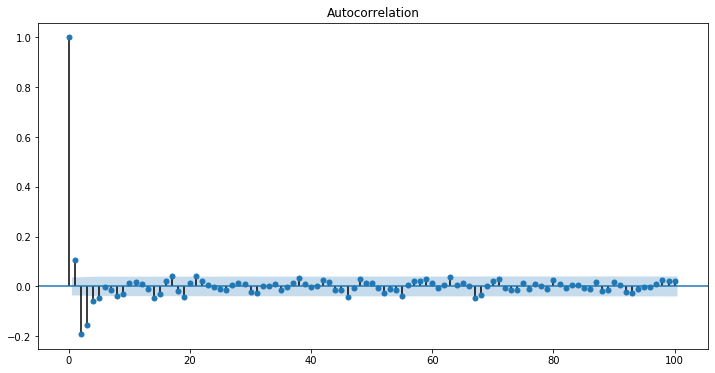

In [63]:
print(plot_acf(y_train.deseasonalized[1:], lags=100))

Figure(864x432)


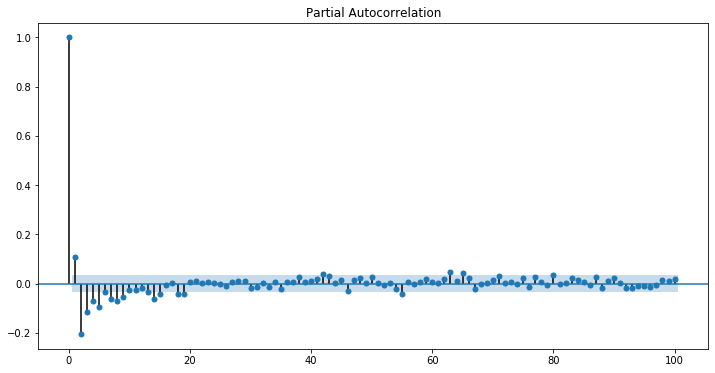

In [64]:
print(plot_pacf(y_train.deseasonalized[1:], lags=100))

In [65]:
m_des = AutoReg(y_train.deseasonalized[1:], lags=1)
res_des = m_des.fit()
print(res_des.summary())

                            AutoReg Model Results                             
Dep. Variable:         deseasonalized   No. Observations:                 2921
Model:                     AutoReg(1)   Log Likelihood              -13226.338
Method:               Conditional MLE   S.D. of innovations             22.435
Date:                Fri, 22 May 2020   AIC                              6.223
Time:                        13:09:19   BIC                              6.229
Sample:                    01-03-2010   HQIC                             6.226
                         - 12-31-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0035      0.415      0.009      0.993      -0.810       0.817
deseasonalized.L1     0.1073      0.018      5.824      0.000       0.071       0.143
                        

### Predict

  
$
y_t = b + w_1y_{t-1} + w_2y_{t-2} + \epsilon_t
$

In [66]:
res_des.params

intercept            0.003538
deseasonalized.L1    0.107331
dtype: float64

In [67]:
# b = parameters[0]
# w1 = parameters[1]
# w2 = parameters[2]

In [68]:
parameters = res_des.params

out_of_sample_stationary = []
for i, date in enumerate(y_test.index):
    last = date - pd.tseries.offsets.DateOffset(days=1)
    if i == 0:
        out_of_sample_stationary.append(res_des.params[0] + res_des.params[1] * y_train.loc[last].deseasonalized + y_test.loc[date].yearly_means + y_train.loc[last].temp)
    else:
        out_of_sample_stationary.append(res_des.params[0] + res_des.params[1] * y_test.loc[last].deseasonalized + y_test.loc[date].yearly_means + y_test.loc[last].temp)

In [69]:
m_nst = AutoReg(y_train.temp, lags=2)
res_nst = m_nst.fit()
parameters_nst = res_nst.params

b = parameters_nst[0]

out_of_sample_nonstationary = []
# create a loop to predict the value for every timestep in y_test
for i in range(len(y_train), len(y_train)+len(y_test)):
    out_of_sample_nonstationary.append(b + sum(df[start_value:].temp[i-1:i].values * parameters_nst[:0:-1].values))
    

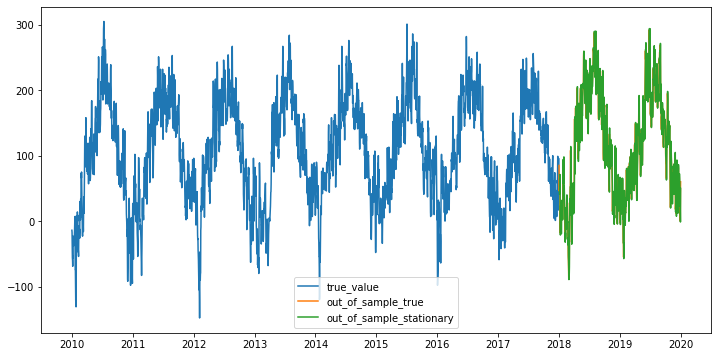

In [70]:

plt.plot(y_train.temp, label='true_value')

#plt.plot(y_train_flights.index[2:], in_sample_stationary, label='stationary_pred')
#plt.plot(y_train_flights.index[2:], in_sample_nonstationary, label='non_stationary_pred')

plt.plot(y_test.temp, label='out_of_sample_true')
#plt.plot(y_test.index, out_of_sample_nonstationary, label='out_of_sample_non_stationary')
plt.plot(y_test.index, out_of_sample_stationary, label='out_of_sample_stationary')
plt.legend()

### SARIMA

p - autoregression order (how many periods we look into the past)  
d - difference order (removing the trend)  
q - number of moving average terms (lags of the forecast errors)  
s - seasonal period length

In [71]:
import itertools
p = (0,1)
d = (0,1)
q = (0,1)
s = 12
pdq = list(itertools.product(p,d,q))
pdqs = [tuple(list(x) + [s]) for x in pdq]
df_parameters=pd.DataFrame({'pdq':pdq,'PDQs':pdqs})
df_parameters

,pdq,PDQs
0,"(0, 0, 0)","(0, 0, 0, 12)"
1,"(0, 0, 1)","(0, 0, 1, 12)"
2,"(0, 1, 0)","(0, 1, 0, 12)"
3,"(0, 1, 1)","(0, 1, 1, 12)"
4,"(1, 0, 0)","(1, 0, 0, 12)"
5,"(1, 0, 1)","(1, 0, 1, 12)"
6,"(1, 1, 0)","(1, 1, 0, 12)"
7,"(1, 1, 1)","(1, 1, 1, 12)"


In [72]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

l_pdq = []
l_pdqs = []
l_aic = []
for i in pdq:
    for j in pdqs:
        model = sm.tsa.statespace.SARIMAX(y_train_mm.temp, order=i, seasonal_order=j, enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit()
        l_pdq.append(i)
        l_pdqs.append(j)
        l_aic.append(results.aic)

In [81]:
df_sarimax = pd.DataFrame()
df_sarimax['pdq'] = l_pdq
df_sarimax['PDQs'] = l_pdqs
df_sarimax['AIC'] = l_aic
df_sarimax.sort_values("AIC", inplace=True)
df_sarimax

,pdq,PDQs,AIC
31,"(0, 1, 1)","(1, 1, 1, 12)",615.612289
63,"(1, 1, 1)","(1, 1, 1, 12)",617.548754
27,"(0, 1, 1)","(0, 1, 1, 12)",618.201102
59,"(1, 1, 1)","(0, 1, 1, 12)",620.122739
15,"(0, 0, 1)","(1, 1, 1, 12)",621.950511
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 12)",972.488121
16,"(0, 1, 0)","(0, 0, 0, 12)",977.755445
32,"(1, 0, 0)","(0, 0, 0, 12)",987.519710
8,"(0, 0, 1)","(0, 0, 0, 12)",1082.961373


In [94]:
#enforce_stationarity (d)
#enforce_invertibility (q)

model = sm.tsa.statespace.SARIMAX(y_train_mm.temp,order=(1, 1, 0), seasonal_order=(0, 0, 0, 12), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
results.aic

972.9189006822892

In [96]:
#pdq / PDQs / AIC
#(0, 1, 1) / (1, 1, 1, 12) / 615.612289

model = sm.tsa.statespace.SARIMAX(y_train_mm.temp, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               temp   No. Observations:                   96
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -303.806
Date:                            Fri, 22 May 2020   AIC                            615.612
Time:                                    14:51:43   BIC                            624.549
Sample:                                01-01-2010   HQIC                           619.158
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0996      0.109    -10.127      0.000      -1.312      -0.887
ar.S.L12      -0.3288      0.167     -1.963      0.050      -0.657      -0.001
ma.S.L12      -0.6805      0.225     -3.029      0.002      -1.121      -0.240
sigma2       288.3920     79.978      3.606      0.000     131.638     445.146
===================================================================================
Ljung-Box (Q):                       31.14   Jarque-Bera (JB):                 3.15
Prob(Q):                              0.84   Prob(JB):                         0.21
Heteroskedasticity (H):               0.60   Skew:                             0.02
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

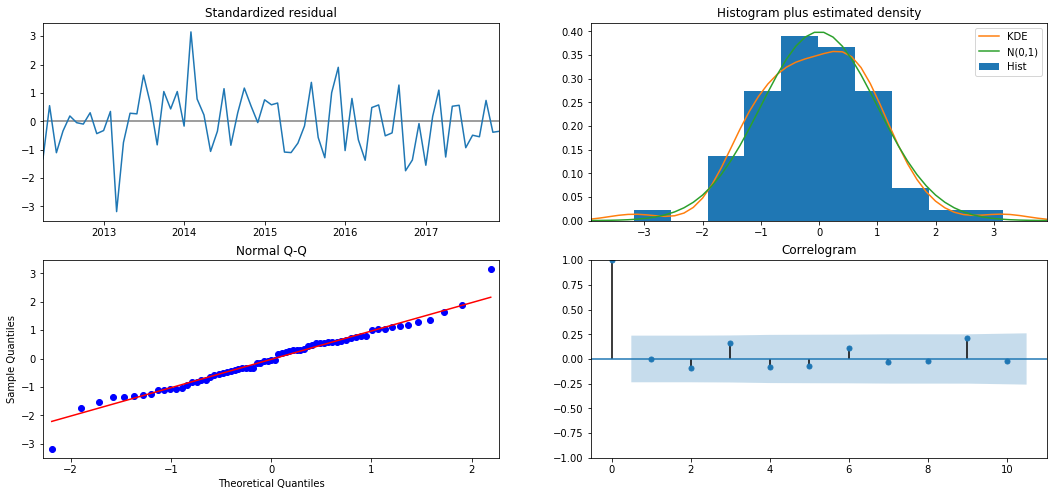

In [77]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Diagnostic plots for standardized residuals

# Standardized residuals over time

# Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.

# Normal Q-Q plot, with Normal reference line.

# Correlogram

In [82]:
#dynamic=False argument ensures that we produce one-step-ahead forecasts
#get_forecast = out-of-sample prediction starting at the end of the sample period.

results.get_forecast(steps=24).summary_frame().head()

temp,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-01-01,12.460111,18.713127,-24.216945,49.137166
2018-02-01,27.003428,18.789539,-9.823392,63.830248
2018-03-01,55.809248,18.865652,18.833250,92.785246
2018-04-01,102.666009,18.941520,65.541312,139.790705
2018-05-01,150.020784,19.017085,112.747982,187.293585


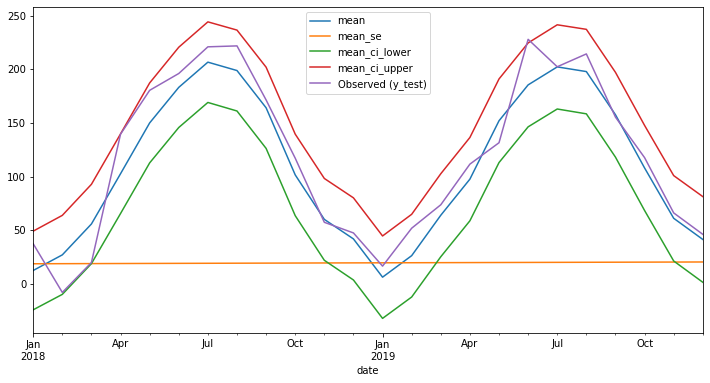

In [90]:
#dynamic=False: one-step-ahead forecasts
#get_forecast: out-of-sample prediction starting at the end of the sample period.

forecast = results.get_forecast(steps=24).summary_frame()
forecast.plot()
y_test_mm.temp.plot(label='Observed (y_test)')
plt.legend()
plt.show()